In [22]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

Here, I set up the data pipeline for the MNIST dataset, crucial for my machine learning model's training and evaluation phases. I resize the images to 224x224 for uniformity, convert them to tensors, and apply normalization to standardize the data. The datasets are divided into training and testing sets, loaded in batches of 64 images, with shuffling enabled to ensure model robustness. Finally, I display key dataset statistics, including sample counts, image dimensions, and class details, to verify the setup and provide insights into the dataset structure.

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

print("Training dataset:")
print("Number of samples:", len(train_data))
print("Shape of images tensor:", train_data.data.shape)
print("Number of classes:", len(train_data.classes))
print("Classes:", train_data.classes)

print("\nTesting dataset:")
print("Number of samples:", len(test_data))
print("Shape of images tensor:", test_data.data.shape)
print("Number of classes:", len(test_data.classes))
print("Classes:", test_data.classes)

Training dataset:
Number of samples: 60000
Shape of images tensor: torch.Size([60000, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Testing dataset:
Number of samples: 10000
Shape of images tensor: torch.Size([10000, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In below snippet, I define a function imshow to visualize images from the training set. The function adjusts the image tensor's normalization, converts it to a NumPy array, and then uses matplotlib to display the image. After fetching a batch of images and their labels from the train_loader, I use torchvision.utils.make_grid to create a grid layout of the images, which is then passed to imshow for visualization. This is a key step in verifying the correct preprocessing and loading of our dataset images.

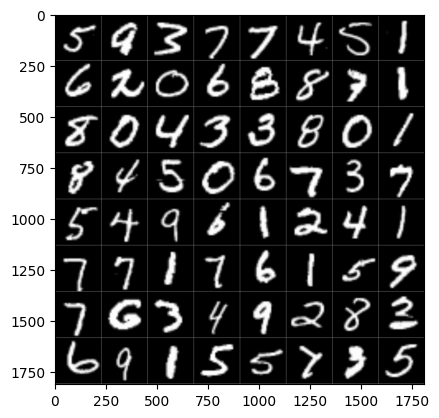

In [20]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

I adapt the ResNet-18 model, pretrained on ImageNet, for the MNIST dataset, which involves grayscale images. I replace the first convolutional layer to accept 1-channel images and modify its weights to aggregate across the channel dimension. The final fully connected layer is customized for the 10 classes of MNIST with a dropout layer added for regularization. I select CrossEntropyLoss for the criterion and Adam as the optimizer with a learning rate of 0.003. The model is configured to run on a GPU if available. Finally, I use the summary function to display the model architecture, ensuring it's correctly set up for the task with the expected input size of 224x224 pixels.

In [26]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
with torch.no_grad():
    model.conv1.weight = nn.Parameter(model.conv1.weight.sum(dim=1, keepdim=True))

model.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, 10)
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

I execute the training and validation loop for my model over 5 epochs. During each epoch, I reset the running loss, set the model to training mode, and iterate over the training dataset in batches. For each batch, I move the images and labels to the appropriate device (GPU/CPU), perform a forward pass to compute the output, calculate the loss, and then perform backpropagation and an optimizer step to update the model weights. I log the loss every 100 batches to monitor the training progress. After iterating through all training batches, I report the average training loss for the epoch.

Subsequently, I switch the model to evaluation mode to assess its performance on the validation (test) dataset. I calculate the validation loss and accuracy, aggregating the results to display them at the end of each epoch. This training-validation cycle helps in understanding how well the model is learning and generalizing to unseen data.

In [28]:
epochs = 5
for epoch in range(epochs):
    print('Epoch ',str(epoch+1),': ')
    running_loss = 0
    model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item()}")

    print(f"Epoch {epoch+1}/{epochs} - Training Loss: {running_loss/len(train_loader)}")

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs} - Validation Loss: {val_loss/len(test_loader)}, Accuracy: {(correct/total)*100}%")

Epoch  1 : 
Epoch 1/5 - Batch 0/938 - Loss: 2.5665762424468994
Epoch 1/5 - Batch 100/938 - Loss: 0.07133746147155762
Epoch 1/5 - Batch 200/938 - Loss: 0.06438431143760681
Epoch 1/5 - Batch 300/938 - Loss: 0.09090159833431244
Epoch 1/5 - Batch 400/938 - Loss: 0.10433021932840347
Epoch 1/5 - Batch 500/938 - Loss: 0.1851680725812912
Epoch 1/5 - Batch 600/938 - Loss: 0.0029394307639449835
Epoch 1/5 - Batch 700/938 - Loss: 0.018211252987384796
Epoch 1/5 - Batch 800/938 - Loss: 0.001821167767047882
Epoch 1/5 - Batch 900/938 - Loss: 0.004797338042408228
Epoch 1/5 - Training Loss: 0.09589503307970537
Epoch 1/5 - Validation Loss: 0.030862241903146445, Accuracy: 98.98%
Epoch  2 : 
Epoch 2/5 - Batch 0/938 - Loss: 0.002939916681498289
Epoch 2/5 - Batch 100/938 - Loss: 0.010813813656568527
Epoch 2/5 - Batch 200/938 - Loss: 0.0037568972911685705
Epoch 2/5 - Batch 300/938 - Loss: 0.05420999974012375
Epoch 2/5 - Batch 400/938 - Loss: 0.02585211955010891
Epoch 2/5 - Batch 500/938 - Loss: 0.034160587936

In [29]:
torch.save(model.state_dict(), 'resnet.pth')

In this section, I configure the model to run on the appropriate device, leveraging CUDA if available, ensuring optimal performance. I also prepare the test dataset with transformations suitable for the model's expected input, such as resizing the images to 224x224, converting them to tensors, and normalizing.

I then proceed to select a subset of images from the test dataset to visually inspect the model's predictions. By iterating through the test dataset in batches, I predict the classes of these images and collect a total of 25 images along with their true and predicted labels. This approach allows for an efficient selection without having to go through the entire dataset.

Finally, I visualize these images in a 5x5 grid, displaying each image with its corresponding predicted and true labels. This visualization is crucial for qualitatively assessing the model's performance, providing immediate insights into its accuracy and potential areas for improvement by directly observing the types of errors it might be making.

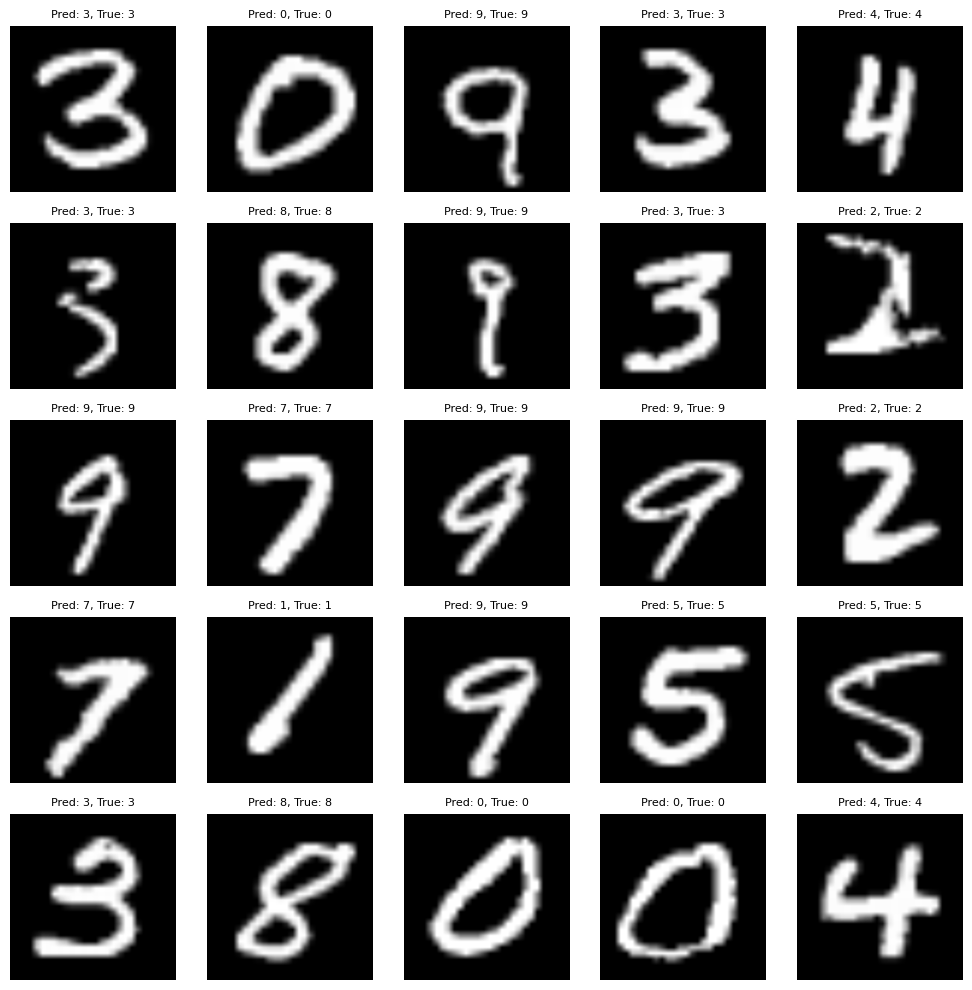

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

random_images = []
random_labels = []
num_images_to_select = 25

selected_images = []
selected_labels = []

predicted_classes = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img, label, pred in zip(images, labels, predicted):
            selected_images.append(img.cpu().numpy().squeeze())
            selected_labels.append(label.item())
            predicted_classes.append(pred.item())
            if len(selected_images) >= num_images_to_select:
                break
        if len(selected_images) >= num_images_to_select:
            break

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i in range(num_images_to_select):
    row = i // 5
    col = i % 5
    axs[row, col].imshow(selected_images[i], cmap='gray')
    axs[row, col].set_title(f"Pred: {predicted_classes[i]}, True: {selected_labels[i]}", fontsize=8)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()